# Surfacing Promotions M2

In [2]:
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import sys
import trino

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(src_path)

from glovo_experimentation_analytics.analytics.experiment import Experiment
from long_term_exp_impact import make_inference
from long_term_exp_impact.config import METRICS
from long_term_exp_impact.load_data import get_harmony_data, agg_harmony_data, create_metrics_query_config, _get_starburst_engine
from long_term_exp_impact.inference import add_metrics_at_unit_level, get_metrics_point_estimates
from long_term_exp_impact.metric import parse_metrics
from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

# Q1: What are the different experiment ids

In [2]:
QUERY_NAME = 'experiments.sql' # With sql
START_DATE = "'2024-07-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df

,experiment_toggle_id,experiment_id,first_exposure_date
0,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10060-ZAP_SURFACING_PROMO...,2024-07-01
1,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
2,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
3,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11134-ZAP_SURFACING_PROMO...,2024-07-18
4,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-19
5,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-26
6,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12294-ZAP_SURFACING_PROMO...,2024-09-03
7,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12327-ZAP_SURFACING_PROMO...,2024-09-05
8,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-06
9,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-17


In [3]:
df['experiment_id'].iloc[11]

'ZAP_SURFACING_PROMOS-13539-ZAP_SURFACING_PROMOS_FF-13490'

# Q2: Check the evolution of variants

In [4]:
QUERY_NAME = 'exposures.sql' # With sql
START_DATE = "'2024-10-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df.head()

,customer_id,variant,first_exposure_at
0,131878899,Promotions enabled,2024-11-05
1,150117496,Control Group,2024-11-21
2,47671156,Control Group,2024-11-06
3,26883937,Promotions enabled,2024-11-02
4,151091471,Control Group,2024-11-04


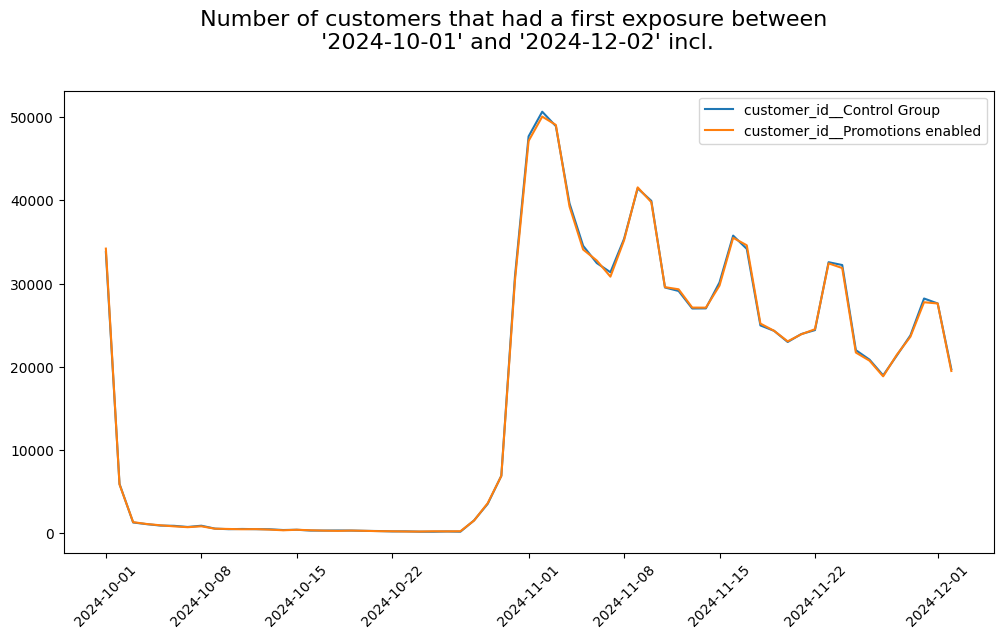

In [5]:
tmp = df.copy()

tmp['first_exposure_at'] = pd.to_datetime(tmp['first_exposure_at'])
grouped = tmp.groupby(['first_exposure_at','variant'])['customer_id'].nunique().reset_index()
grouped.sort_values(by=['first_exposure_at','variant'],ascending=[True,True], inplace=True)
pivot = grouped.pivot(index = 'first_exposure_at', columns='variant', values=['customer_id'])
pivot.columns = [f'{col[0]}__{col[1]}' for col in pivot.columns]
pivot = pivot.reset_index()
pivot = pivot.fillna(0)

v = dataframe_visualizer.DataFrameVisualizer(pivot)

plot_params = [
    {
        'plot_type': 'lineplot', 
        'x_column': 'first_exposure_at', 
        'y_columns': ['customer_id__Control Group', 'customer_id__Promotions enabled'],
        'colors': ['blue', 'orange'],
        'legend': True
    }
]

figure_params = {
    'n_plots': 1,
    'fig_length': 12,
    'fig_height': 6, 
    'x_rotation': 45,
    'x_limits': None, 
    'y_limits': None, 
    'title': f' Number of customers that had a first exposure between \n {START_DATE} and {END_DATE} incl.'
}

v.plot(figure_params=figure_params, plot_params=plot_params)


# Q3: Harmony metric

In [12]:
dotenv.load_dotenv()
conn = _get_starburst_engine()

In [13]:
exp_exposures_sql_path = "queries/exposures_harmony.sql"
exp_exposures_sql_config = {
    'end_date':"2024-11-24",
    'num_days':29
}
exp_metrics_query_config = create_metrics_query_config(
    end_date="2024-11-24",
    num_days=29,
    city_codes="all"
)

In [14]:
exp_df = get_harmony_data(
    conn=conn,
    exposures_sql_path=exp_exposures_sql_path,
    exposure_sql_config=exp_exposures_sql_config,
    metrics_query_config=exp_metrics_query_config
)

Started collecting data for harmony metrics ...
Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/0f1ff6df59ad6cd1b01b34ab1fcdd0906d6e7774bd45f9dafc80f5fce789531c
Started collecting data for customer exposures using your query ...
Started processing the data to create the final dataset for analysis ...
Loading data is completed.


In [30]:
exp_df_agg = exp_df.pipe(agg_harmony_data, groupby_cols=('customer_id','variant'))

print(exp_df_agg.shape)
exp_df_agg.head()

(1533623, 14)


,customer_id,variant,total_orders_cancelled,total_orders_delivered,total_dt_minutes,total_cdt_minutes,total_orders_created,total_long_orders,total_late_orders,total_cpo,total_cm,total_ads_revenue,total_delivered_orders_eta,one
0,220,Control Group,0.0,7.0,145.650000,96.183333,7.0,0.0,0.0,28.26380,23.633874,1.346570,7.0,1
1,223,Promotions enabled,1.0,11.0,299.350000,199.350000,12.0,0.0,1.0,33.53815,13.968854,0.000000,11.0,1
2,273,Promotions enabled,0.0,3.0,67.866667,37.000000,3.0,0.0,0.0,9.53630,-46.937800,1.132667,3.0,1
3,287,Promotions enabled,0.0,10.0,263.316667,159.791667,10.0,0.0,0.0,24.25410,68.453500,0.000000,9.0,1
4,296,Promotions enabled,0.0,3.0,108.233333,69.916667,3.0,1.0,0.0,6.21120,14.851300,1.058762,2.0,1


In [31]:
variant_map = {
    "Control Group": "control",
    "Promotions enabled": "treatment"
}

exp_df_agg['variant'] = exp_df_agg['variant'].map(variant_map)

In [32]:
alpha=0.1

results = make_inference(
    df=exp_df_agg,
    alpha=alpha
)

results

{'estimand': 'relative effect on 1y CM',
 'point_estimate': -0.0014757835728109493,
 'ci_low': -0.009104585666651285,
 'ci_upp': 0.006153018521029387,
 'std_err': 0.004637982352253042,
 'alpha': 0.1,
 'n_largest': 768472}

In [34]:
proxy_results = get_metrics_point_estimates(add_metrics_at_unit_level(exp_df_agg, parse_metrics(METRICS)))

proxy_results

{'m_cancellation_rate': {'control': 0.0301106264138789,
  'treatment': 0.030017727122772602},
 'm_customer_dt': {'control': 34.50513361814363,
  'treatment': 34.54731095377211},
 'm_courier_dt': {'control': 16.629808796119807,
  'treatment': 16.64180049414764},
 'm_orders_created': {'control': 3.0390489178525697,
  'treatment': 3.0449283866844583},
 'm_long_orders_rate': {'control': 0.0771564920981578,
  'treatment': 0.07728711038270031},
 'm_late_orders_rate': {'control': 0.049992950819268224,
  'treatment': 0.049794457606151594},
 'm_cpo': {'control': 2.8387333105573194, 'treatment': 2.839893994559682},
 'm_cm': {'control': 4.3537633707272105, 'treatment': 4.342134461271897},
 'm_ads': {'control': 0.7998973281059885, 'treatment': 0.8025184199716409},
 'units': {'control': 768472, 'treatment': 765151}}

# Q4: Flickering between versions of the experiments

There is no problem, as all the experiment occurs in the same experiment version - as checked in Q1

# Q5: Order level metrics

In [3]:
QUERY_NAME = 'metrics_customer_level.sql' # With sql
START_DATE = "'2024-10-25'"
END_DATE = "'2024-11-23'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df

,customer_id,variant,first_exposure_at,groceries_delivered_orders,groceries_delivered_orders_with_discounts,groceries_total_gmv,groceries_discounted_gmv
0,148935247,Control Group,2024-11-03,0,0,0.000000,0.000000
1,118248422,Control Group,2024-10-31,4,0,87.702072,0.000000
2,159190220,Control Group,2024-10-31,1,0,48.082070,0.000000
3,15765485,Control Group,2024-10-29,4,1,37.661612,1.389138
4,176270160,Promotions enabled,2024-10-31,1,0,6.648610,0.000000
...,...,...,...,...,...,...,...
1662192,180835634,Promotions enabled,2024-11-07,0,0,0.000000,0.000000
1662193,137257096,Control Group,2024-11-01,0,0,0.000000,0.000000
1662194,1746013,Control Group,2024-11-07,0,0,0.000000,0.000000
1662195,181621738,Control Group,2024-11-22,0,0,0.000000,0.000000


In [4]:
METRIC_NAME = 'groceries_discounted_gmv'

unique_customers = df.groupby('variant')['customer_id'].nunique()
groceries_with_discounts = df.groupby('variant')[METRIC_NAME].sum()

result = groceries_with_discounts / unique_customers
result_df = result.reset_index(name='metric')
result_df

,variant,metric
0,Control Group,0.296404
1,Promotions enabled,0.308649


In [41]:
df['aov'] = df['groceries_delivered_orders_with_discounts']/df['groceries_delivered_orders']
df['aov'] = df['aov'].fillna(0)

In [42]:
df.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,832265,0.500702
Promotions enabled,829932,0.499298


In [43]:
df.columns

Index(['customer_id', 'variant', 'first_exposure_at',
       'groceries_delivered_orders',
       'groceries_delivered_orders_with_discounts', 'groceries_total_gmv',
       'groceries_discounted_gmv', 'aov', 'date'],
      dtype='object')

                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-07-04 to │  ['Groceries │     ['Control │        True │  0.05 │       0.0125 │
│ promos for   │ surfacing    │    2024-08-16 │    delivered │       Group', │             │       │              │
│ Groceries    │ promotions   │               │     orders', │   'Promotions │             │       │              │
│              │ will         │               │   'Groceries │     enabled'] │             │       │              │
│              │ increase the │               │    delivered │               │             │       │              │
│              │ number of    │               │  orders with │               │             │       │              │
│              │ customers    │               │  discounts', │               │             │       │              │
│              │ that         │               │   'Groceries │               │             │       │              │
│              │ interact     │               │  total GMV', │               │             │       │              │
│              │ with         │               │   'Groceries │               │             │       │              │
│              │ Promotions   │               │   discounted │               │             │       │              │
│              │              │               │        GMV'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS                                                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.107616,1.110927,0.003311,-0.00597,0.012592,0.372885,0.003716,False


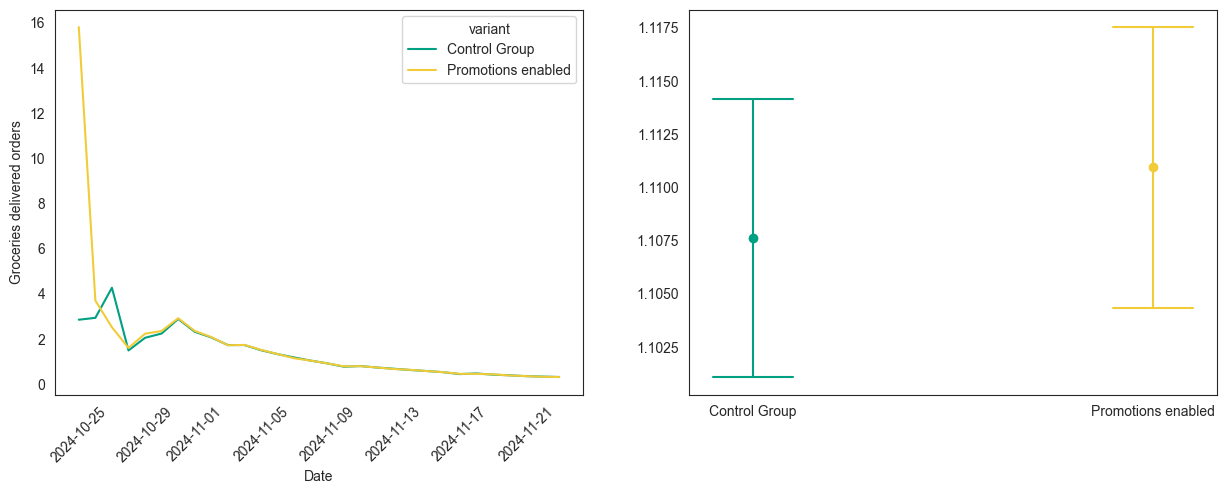

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS WITH DISCOUNTS                                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.182768,0.189522,0.006754,0.003973,0.009535,1.315806e-09,0.001114,True


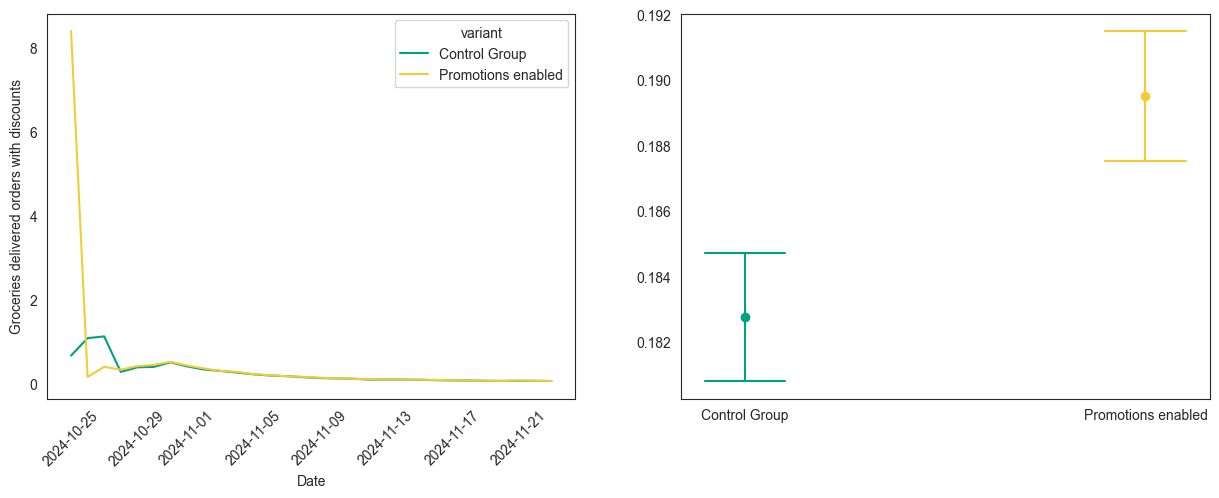

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES TOTAL GMV                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,27.71239,28.192904,0.480514,0.125411,0.835617,0.000725,0.142172,True


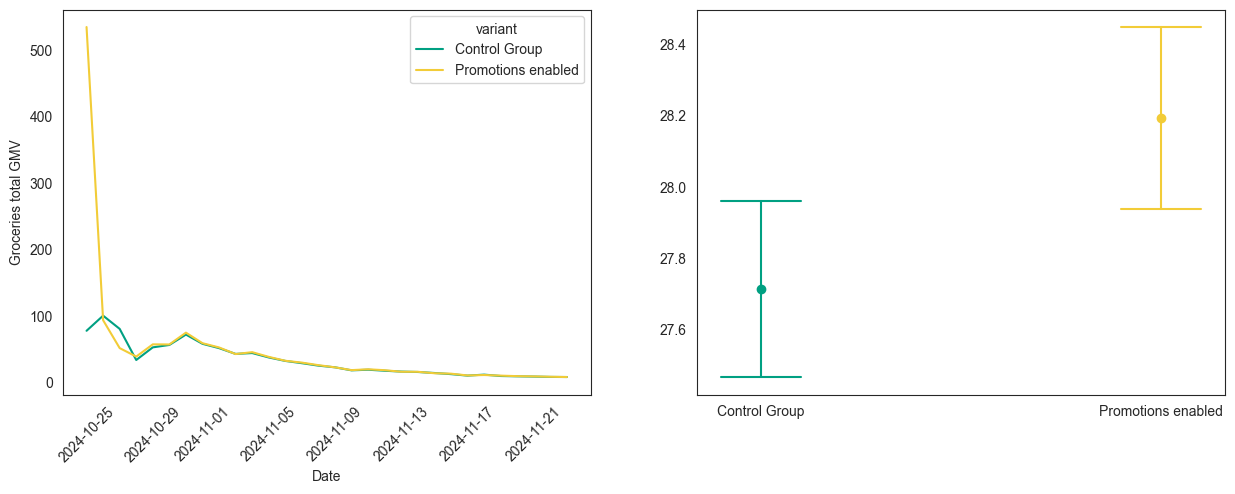

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DISCOUNTED GMV                                                                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.296404,0.308649,0.012245,0.005232,0.019258,0.000013,0.002808,True


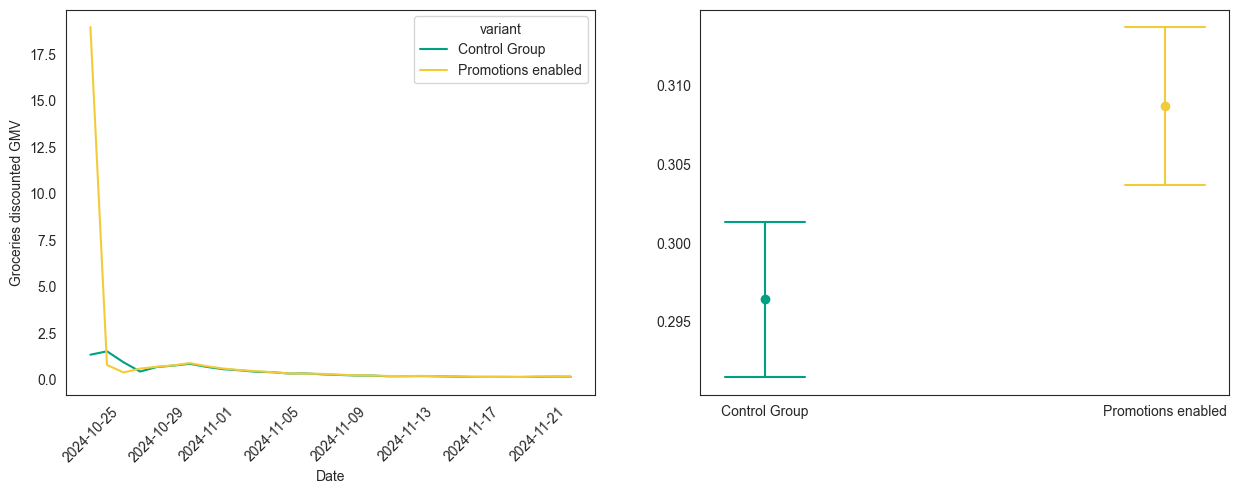

In [6]:
### Orders and GMV
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Groceries delivered orders",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders",
            },   
            {
                "metric_name": "Groceries delivered orders with discounts",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders_with_discounts",
            },
            {
                "metric_name": "Groceries total GMV",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_total_gmv",
            },  
            {
                "metric_name": "Groceries discounted GMV",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_discounted_gmv",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()

# Q6: Session level metrics

In [36]:
QUERY_NAME = 'metrics_sessions_customer_level.sql' # With sql
START_DATE = "'2024-10-25'"
END_DATE = "'2024-11-23'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()
df

/Users/jordicremades/Documents/repos/central-node/src/query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/7b9264ca62eb41185660efb8577d858e06136cb7049da3257dc9c7cee0754b23


,customer_id,variant,first_exposure_at,banner_impressions,distinct_banner_impressions_per_session,widget_collection_impressions,collection_opened,distinct_collection_opened_per_session,store_access_session,order_created_session
0,106580814,Control Group,2024-11-18,0,0,0,20,16,3,1
1,68021938,Control Group,2024-11-02,0,0,0,6,6,5,0
2,850881,Promotions enabled,2024-11-05,2,2,0,11,4,5,3
3,118407117,Control Group,2024-10-31,4,3,0,191,90,30,11
4,86365376,Promotions enabled,2024-10-30,5,3,0,53,50,5,3
...,...,...,...,...,...,...,...,...,...,...
1662192,17357531,Promotions enabled,2024-11-15,0,0,1,10,7,1,0
1662193,181450206,Promotions enabled,2024-11-19,0,0,0,0,0,1,0
1662194,12714913,Promotions enabled,2024-11-10,0,0,0,0,0,1,0
1662195,27371085,Control Group,2024-11-22,0,0,0,0,0,1,0


In [37]:
df.columns

Index(['customer_id', 'variant', 'first_exposure_at', 'banner_impressions',
       'distinct_banner_impressions_per_session',
       'widget_collection_impressions', 'collection_opened',
       'distinct_collection_opened_per_session', 'store_access_session',
       'order_created_session'],
      dtype='object')

In [39]:
METRIC_NAME = 'widget_collection_impressions'

unique_customers = df.groupby('variant')['customer_id'].nunique()
groceries_with_discounts = df.groupby('variant')[METRIC_NAME].sum()

result = groceries_with_discounts / unique_customers
result_df = result.reset_index(name='metric')
result_df

,variant,metric
0,Control Group,0.000117
1,Promotions enabled,2.617371


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-07-04 to │ ['Collectio… │     ['Control │        True │  0.05 │       0.0100 │
│ promos for   │ surfacing    │    2024-08-16 │ impressions… │       Group', │             │       │              │
│ Groceries    │ promotions   │               │    'Distinct │   'Promotions │             │       │              │
│              │ will         │               │ Collection_… │     enabled'] │             │       │              │
│              │ increase the │               │  impressions │               │             │       │              │
│              │ number of    │               │          per │               │             │       │              │
│              │ customers    │               │    session', │               │             │       │              │
│              │ that         │               │      'Widget │               │             │       │              │
│              │ interact     │               │   collection │               │             │       │              │
│              │ with         │               │ impresions', │               │             │       │              │
│              │ Promotions   │               │  'Collection │               │             │       │              │
│              │              │               │     opened', │               │             │       │              │
│              │              │               │    'Distinct │               │             │       │              │
│              │              │               │   collection │               │             │       │              │
│              │              │               │   opened per │               │             │       │              │
│              │              │               │    session'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION_SHOPPABLE_BANNER IMPRESSIONS                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,3.100029,3.128439,0.02841,-0.010195,0.067015,0.058017,0.014988,False


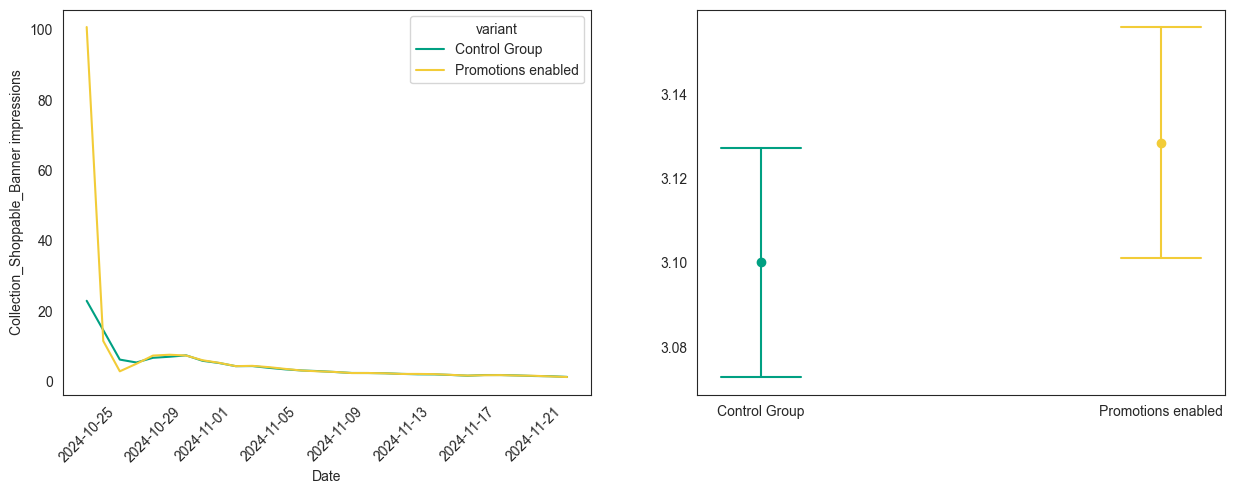

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION_SHOPPABLE_BANNER IMPRESSIONS PER SESSION                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.275239,1.28605,0.010811,-0.002688,0.024309,0.039116,0.00524,False


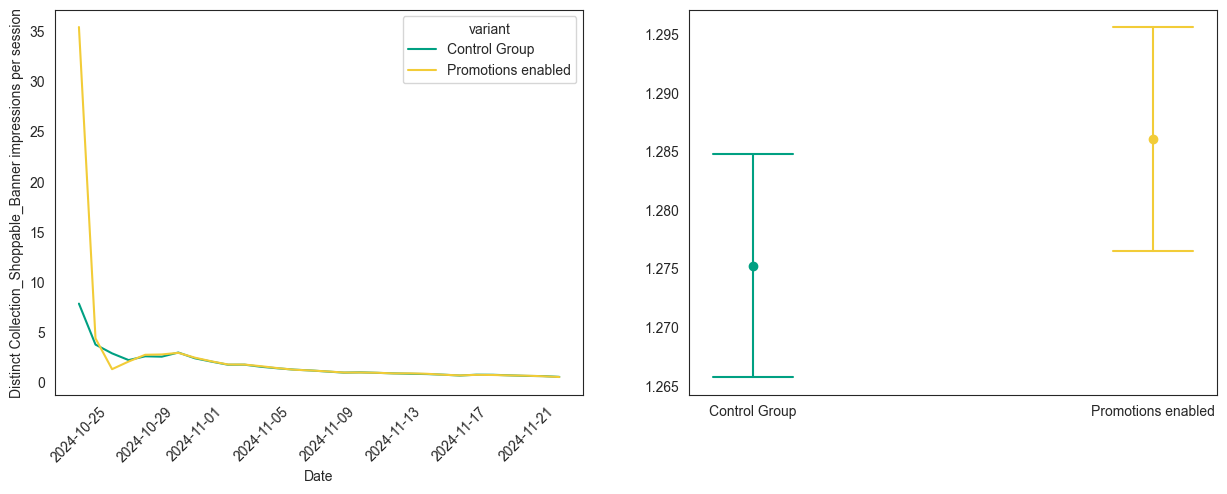

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ WIDGET COLLECTION IMPRESIONS                                                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.000117,2.617371,2.617255,2.587639,2.64687,0.0,0.011498,True


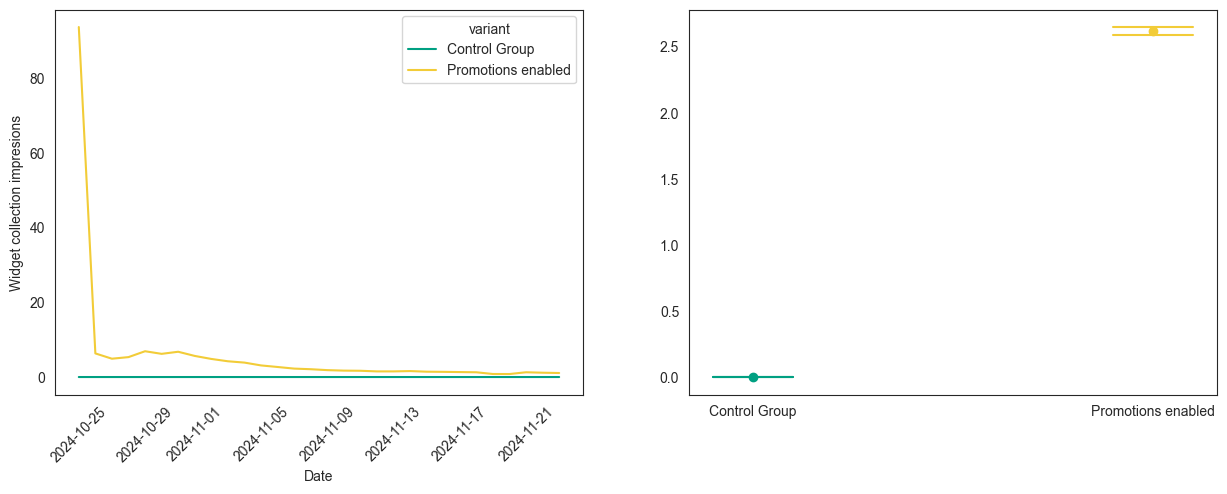

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION OPENED                                                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,19.526837,19.680122,0.153285,-0.030449,0.337019,0.031638,0.07133,False


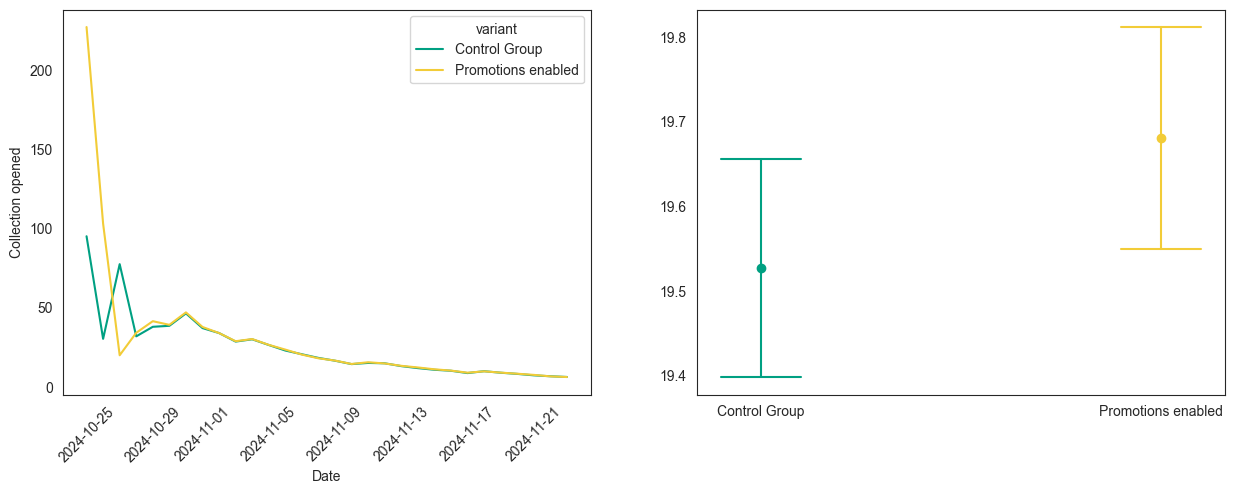

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION OPENED PER SESSION                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,15.026263,15.25864,0.232377,0.09261,0.372144,0.000018,0.054261,True


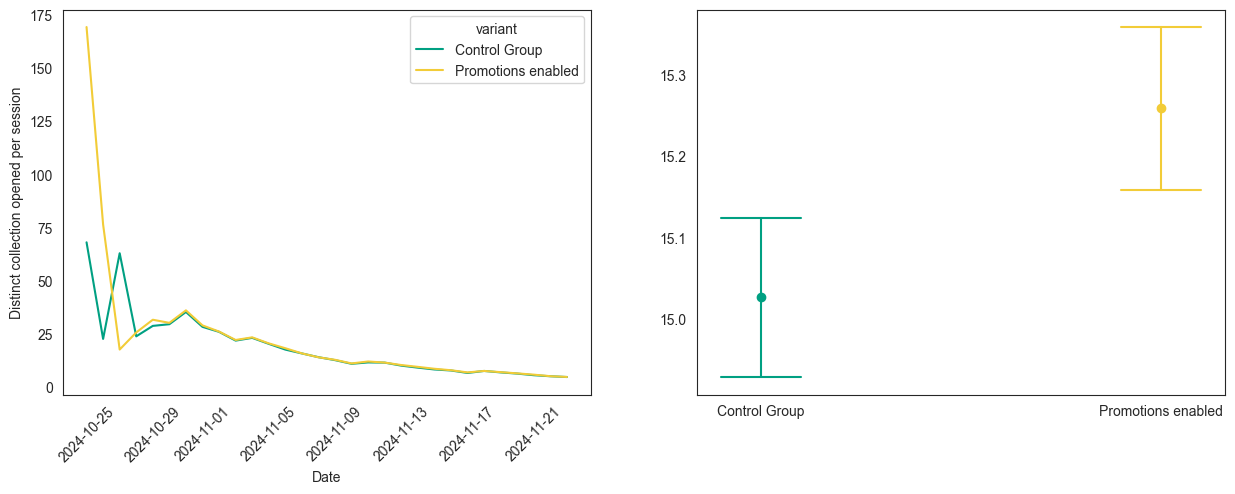

In [43]:
### Orders and GMV
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Collection_Shoppable_Banner impressions",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "banner_impressions",
            },   
            {
                "metric_name": "Distinct Collection_Shoppable_Banner impressions per session",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_banner_impressions_per_session",
            },
            {
                "metric_name": "Widget collection impresions",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "widget_collection_impressions",
            },  
            {
                "metric_name": "Collection opened",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "collection_opened",
            },   
            {
                "metric_name": "Distinct collection opened per session",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_collection_opened_per_session",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()